# Install necessary libraries

In [1]:
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import powerlaw
import re
import pandas as pd
import hashlib
import math
import os

from bs4 import BeautifulSoup
from itertools import combinations
from collections import Counter
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

# Month to number mapping

In [2]:
month_map = {
    "Ocak": 1,
    "Şubat": 2,
    "Mart": 3,
    "Nisan": 4,
    "Mayıs": 5,
    "Haziran": 6,
    "Temmuz": 7,
    "Ağustos": 8,
    "Eylül": 9,
    "Ekim": 10,
    "Kasım": 11,
    "Aralık": 12
}

# Config parameters

In [3]:
start_date_str = "1.5.2016"
end_date_str = "1.9.2016"

# Only look at edits that changed the file size more than byte_threshold bytes
byte_threshold = 10

# Only analyze editors with edit count >= edit_threshold
edit_threshold = 0

# Function declerations and constructing datetime objects

In [4]:
def ip_to_unique_hash(ip_address):
    return hashlib.sha256(ip_address.encode()).hexdigest()

def get_country_from_ip(ip_address):
    response = requests.get(f'https://ipinfo.io/{ip_address}/json', headers={'Authorization': 'Bearer c4649199cacb96'})
    if response.status_code == 200:
        data = response.json()
        return data.get('country', 'Country information not available')
    else:
        print("Failed to retrieve data: ", response.status_code, response.text) 
        return "Failed to retrieve data"

def is_ipv4(address):
    pattern = re.compile(r'^(\d{1,3}\.){3}\d{1,3}$')
    return pattern.match(address) is not None

def is_ipv6(address):
    pattern = re.compile(r'^([\da-fA-F]{1,4}:){7}[\da-fA-F]{1,4}$')
    return pattern.match(address) is not None

def add_name_to_byte_dict(dictionary, name, date_obj, byte_changes):
    if (name not in dictionary):
        dictionary[name] = {date_obj: byte_changes}
    elif date_obj not in dictionary[name]:
        dictionary[name][date_obj] =  byte_changes
    else:
        dictionary[name][date_obj] += byte_changes

def get_datetime(start_date_string, end_date_string):
    start_date_elems = start_date_string.split(".")
    start_date = datetime.datetime(int(start_date_elems[2]), int(start_date_elems[1]), int(start_date_elems[0]))

    end_date_elems = end_date_string.split(".")
    end_date = datetime.datetime(int(end_date_elems[2]), int(end_date_elems[1]), int(end_date_elems[0]))
    
    return start_date, end_date

start_date, end_date = get_datetime(start_date_str, end_date_str)

# Helper function to add name to byte change dictionary
def add_name_to_byte_dict(byte_dict, name, date_obj, byte_changes):
    if name not in byte_dict:
        byte_dict[name] = {}
    if date_obj not in byte_dict[name]:
        byte_dict[name][date_obj] = 0
    byte_dict[name][date_obj] += byte_changes

## Set of politicians 

In [5]:
sample_set = {
    "Recep_Tayyip_Erdoğan":"AKP",
    "Murat_Kurum":"AKP",
    "Mehmet_Şimşek":"AKP",
    "Süleyman_Soylu":"AKP",
    "Berat_Albayrak":"AKP",
    "Efkan_Âlâ":"AKP",
    "Binali_Yıldırım":"AKP",
    "Özgür_Özel":"CHP",
    "Mansur_Yavaş":"CHP",
    "Kemal_Kılıçdaroğlu":"CHP",
    "Ekrem_İmamoğlu":"CHP",
    "Meral_Akşener":"İYİ",
    "Uğur_Poyraz":"İYİ",
    "Kürşad_Zorlu":"İYİ",
    "Koray_Aydın":"İYİ",
    "Devlet_Bahçeli":"MHP",
    "Edip_Semih_Yalçın":"MHP",
    "Feti_Yıldız":"MHP",
    "Mustafa_Kalaycı":"MHP",
    "İsmail_Özdemir":"MHP",
    "Pervin_Buldan":"DEM",
    "Tülay_Hatimoğulları_Oruç":"DEM",
    "Selahattin_Demirtaş":"DEM",
    "Sırrı_Süreyya_Önder":"DEM",
    "Ahmet_Davutoğlu":"GEL",
    "Ali_Babacan":"DEVA",
    "Fatih_Erbakan":"YRP"
}

politician_number = len(sample_set)

## Retrieving the revision data

In [6]:
import datetime
import pickle
import os
import requests

# Function to save revision_dict with metadata
def save_revision_data(revision_dict, start_date, end_date, filename="revision_data.pkl"):
    data_to_save = {
        "revision_dict": revision_dict,
        "start_date": start_date,
        "end_date": end_date,
        "num_politicians": len(revision_dict)
    }
    with open(filename, "wb") as f:
        pickle.dump(data_to_save, f)
        
    print(f"Data saved to {filename}")

# Function to load revision data if it exists
def load_revision_data(filename="revision_data.pkl"):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            data = pickle.load(f)
        return data
    return None

def fetch_edit_history(politician_name, start_date, end_date, byte_threshold, person_counter):
    politician_name = politician_name.strip()
    
    # Initialize the revision_dict for the current politician
    revision_dict[politician_name] = list()  
    
    print(f"Retrieving revision data for {person_counter} out of {politician_number}:", politician_name, "")
    
    continue_fetching = True
    rvcontinue = None
    
    # Continue to loop as long as there are more revision history pages exist in the valid time range
    while continue_fetching:
        params = {
            "action": "query",
            "format": "json",
            "prop": "revisions",
            "titles": politician_name,
            "rvlimit": "max",
            "rvprop": "ids|timestamp|user|size|comment|sha1"
        }
        if rvcontinue:
            params["rvcontinue"] = rvcontinue
        
        # Request the revision history page from API
        response = requests.get("https://tr.wikipedia.org/w/api.php", params=params).json()
        
        page_id = list(response['query']['pages'].keys())[0]
        if page_id == "-1":
            print(f"Page not found for {politician_name}")
            return
        
        # Get all the revisions from the current page
        revisions = response['query']['pages'][page_id].get('revisions', [])
        
        for rev in revisions:
            # Date of the revision
            date_obj = datetime.datetime.strptime(rev['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
            
            # Check the date of the revision
            if date_obj < start_date:
                # If date is older then the target time range, then it means we have retrieved all valid revisions. Stop the search
                
                continue_fetching = False
                revision_dict[politician_name].append(["__OUT_OF_RANGE_EDITOR__" , date_obj, rev["size"], 0, 0, "", rev["revid"]])
                break
                
            if start_date <= date_obj <= end_date:
                # Revision is in the valid range
                
                revid = rev["revid"]   # Revision id
                revision_dict[politician_name].append(["" , date_obj, rev["size"], 0, 0, "", rev["revid"]])   # Initialize revision entry for the dictionary
                          
                if "sha1hidden" in rev:
                    # If revision hidden, it means the revision is deleted
                    revision_dict[politician_name][-1][4] = 1
        
                if "user" not in rev:
                    # No username key in revision data, user name is deleted.
                    user_name = "__NO_NAME_EDITOR__"
                else:
                    # A valid username
                    user_name = rev["user"]
                
                # Add the username to revision entry
                revision_dict[politician_name][-1][0] = user_name
                    
                if is_ipv4(user_name) or is_ipv6(user_name):
                    # Username is an IP address. Convert it to a unique id, and turn on the corresponding flags
                    
                    unique_name = ip_to_unique_hash(user_name)
                    revision_dict[politician_name][-1][3] = 1
                    revision_dict[politician_name][-1][0] = unique_name
                    revision_dict[politician_name][-1][5] = user_name

                    
        # Check if there are more revisions to fetch
        if "continue" in response:
            rvcontinue = response["continue"]["rvcontinue"]
        else:
            continue_fetching = False

download_new_data = False


# Check if saved data exists and prompt the user
saved_data = load_revision_data()
if saved_data:
    saved_start_date = saved_data["start_date"]
    saved_end_date = saved_data["end_date"]
    saved_num_politicians = saved_data["num_politicians"]

    print(f"Previously fetched data already exists from {saved_start_date} to {saved_end_date} with {saved_num_politicians} politicians.")
    user_input = input(f"Do you want to use the existing data? (yes/no): ")
    if user_input.lower() == "yes":
        print("Using the saved data.")
        revision_dict = saved_data["revision_dict"]
    else:
        print("Proceeding to update the data.")
        download_new_data = True
else:
    print("No revision data exists. Fetching new data...")
    download_new_data = True

if download_new_data:
    revision_dict = dict()

    person_counter = 1
    for name in sample_set.keys():
        # Retrieve all the revision history for targeted politicians
        fetch_edit_history(name, start_date, end_date, byte_threshold, person_counter)

        person_counter += 1

    print("Finished scraping with Wikipedia API")

    # Save the revision_dict with metadata after fetching the data
    save_revision_data(revision_dict, start_date, end_date)


Previously fetched data already exists from 2013-04-01 00:00:00 to 2024-08-01 00:00:00 with 27 politicians.
Do you want to use the existing data? (yes/no): yes
Using the saved data.


# Analyzing revision data and constructing data structures

In [7]:
# Flag for removing "bot" editors
bot_removal = True


# Dictionary for a network; where nodes are editors, and edges are commonly edited politicians
editors = dict()

# Dictionary for a network; where nodes are politicians, and edges are shared editors
politicians = dict()

# Dictionary for a network, where nodes are editors with ip addresses, and edges are commonly edited politicians
nonreg_editors = dict()

# Dictionaries for editors and politicians who had an edit that was removed
editors_with_removed_edits = {"NO_NAME": 0, "IP_BASED": 0, "REGISTERED": 0}
politicians_with_removed_edits = {}

# Byte distribution dictionaries. Keys are politician names, values are dictionary objects as date:total_change
positive_changes = {}
negative_changes = {}
net_changes = {}

# Positive and negative byte change distribution lists for all politicians
positive_distribution = []
negative_distribution = []


for politician_name, revision_list in revision_dict.items():
    revision_values = revision_list  # Rename the revision list (not necessary, I was just lazy to change all names to revision_list below)
    
    # Initialize the politician entry for the politicians dictionary
    politicians[politician_name] = [dict(), sample_set[politician_name]]
    
    # Initialize the removed-total edit counters
    politicians_with_removed_edits[politician_name] = [0, 0]

    for i in range(len(revision_values) - 2, -1, -1):
        ###############################################################################
        # Index => 0: editor name, 1: date object, 2: file size in bytes, 3: (bool)non-registered editor, 4: (bool)removed edit, 5: IP_address (if bool[3]==true)
        
        byte_change = revision_values[i][2] - revision_values[i+1][2]
        politician_party = politicians[politician_name][1]
        editor_name = revision_values[i][0]
        date = revision_values[i][1]
        
        """if "bot" in editor_name.lower():
            continue"""
            
        if abs(byte_change) >= 0.5* revision_values[i][2]:
            continue

        if abs(byte_change) >= byte_threshold and start_date <= date <= end_date:
            ###############################################################################
            ################### CONSTRUCTING BYTE CHANGE DICTIONARIES #####################
            politicians_with_removed_edits[politician_name][1] += 1

            add_name_to_byte_dict(net_changes, politician_name, date, byte_change)
            if byte_change > 0:
                add_name_to_byte_dict(positive_changes, politician_name, date, byte_change)
                positive_distribution.append(byte_change)
            else:
                add_name_to_byte_dict(negative_changes, politician_name, date, byte_change)
                negative_distribution.append(byte_change)

            ###############################################################################
            ################### CONSTRUCTING EDITORS WITH REMOVED EDITS DICTIONARY ########
            if revision_values[i][4] == 1:
                politicians_with_removed_edits[politician_name][0] += 1

                if editor_name == "__NO_NAME_EDITOR__":
                    editors_with_removed_edits["NO_NAME"] += 1
                elif revision_values[i][3] == 1:
                    editors_with_removed_edits["IP_BASED"] += 1
                else:
                    editors_with_removed_edits["REGISTERED"] += 1

            ###############################################################################
            ################## CONSTRUCTING EDITORS DICTIONARIES ##########################
            if revision_values[i][3] == 1:
                if editor_name not in nonreg_editors:
                    nonreg_editors[editor_name] = [dict(), dict(), 0, revision_values[i][5]]

                if politician_name not in nonreg_editors[editor_name][0]:
                    nonreg_editors[editor_name][0][politician_name] = 0
                nonreg_editors[editor_name][0][politician_name] += 1

                nonreg_editors[editor_name][2] += 1

                if politician_party not in nonreg_editors[editor_name][1]:
                    nonreg_editors[editor_name][1][politician_party] = 0
                nonreg_editors[editor_name][1][politician_party] += 1
            else:
                if editor_name not in editors:
                    editors[editor_name] = [dict(), dict(), 0, dict()]
                    
                if politician_name not in editors[editor_name][0]:
                    editors[editor_name][0][politician_name] = 0
                    editors[editor_name][3][politician_name] = 0
                
                editors[editor_name][0][politician_name] += 1
                editors[editor_name][3][politician_name] += abs(byte_change)
                
                editors[editor_name][2] += 1

                if politician_party not in editors[editor_name][1]:
                    editors[editor_name][1][politician_party] = 0
                editors[editor_name][1][politician_party] += 1
                ###############################################################################
                ################## CONSTRUCTING POLITICIANS DICTIONARY ########################
                if editor_name not in politicians[politician_name][0]:
                    politicians[politician_name][0][editor_name] = 0
                politicians[politician_name][0][editor_name] += 1

print("Finished constructing necessary data structures.")


Finished constructing necessary data structures.


## Filter editors with edits below edit_threshold

In [8]:
editors_to_remove = dict()

def filter_editors(dict_to_update, copy_dict):
    dict_to_update.clear()

    for key, val in copy_dict.items():
        if val[2] >= edit_threshold:
            dict_to_update[key] = val
        else:
            editors_to_remove[key] = 1

def filter_editors_from_politicians(politician_dict):
    for name in editors_to_remove.keys():
        for politician_name in politicians.keys():
            if name in politicians[politician_name][0]:
                
                del politicians[politician_name][0][name]
                
    
editors_copy = editors.copy()
nonreg_editors_copy = nonreg_editors.copy()

filter_editors(editors, editors_copy)
filter_editors(nonreg_editors, nonreg_editors_copy)
filter_editors_from_politicians(politicians)

## Distribution of byte changes (positive and negative)

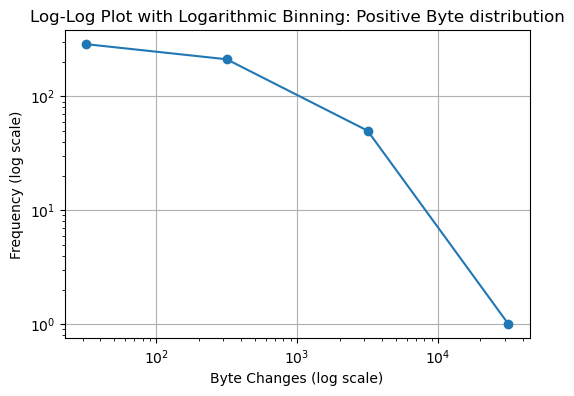

Calculating best minimal value for power law fit
Power-law exponent (alpha): 2.3732946123317546
Minimum value for power-law fit (xmin): 641.0


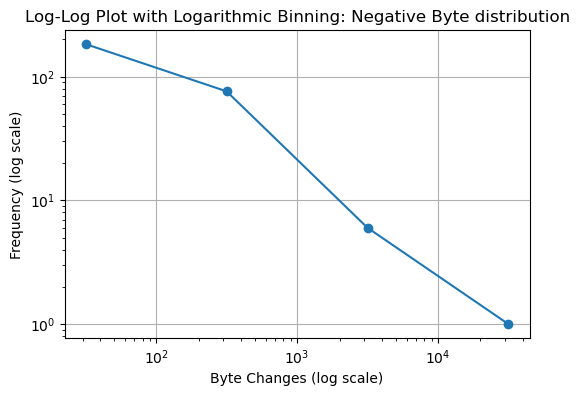

Calculating best minimal value for power law fit
Power-law exponent (alpha): 1.966307064091203
Minimum value for power-law fit (xmin): 83.0


In [9]:
pos_data = np.array(positive_distribution)

# Create logarithmic bins
min_exp = np.floor(np.log10(min(pos_data)))
max_exp = np.ceil(np.log10(max(pos_data)))
bins = np.logspace(min_exp, max_exp, num=int(max_exp-min_exp)+1)

# Calculate histogram
hist, edges = np.histogram(pos_data, bins=bins)

# Calculate bin centers
bin_centers = 10**(np.log10(edges[:-1]) + np.log10(edges[1:]/edges[:-1])/2)

# Plot on a log-log scale
plt.figure(figsize=(6, 4))
plt.loglog(bin_centers, hist, marker='o', linestyle='-')
plt.title('Log-Log Plot with Logarithmic Binning: Positive Byte distribution')
plt.xlabel('Byte Changes (log scale)')
plt.ylabel('Frequency (log scale)')
plt.grid(True)

# Show the plot
plt.show()

results = powerlaw.Fit(pos_data)
print('Power-law exponent (alpha):', results.power_law.alpha)
print('Minimum value for power-law fit (xmin):', results.power_law.xmin)

#///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

neg_data = np.array(negative_distribution)

neg_data = np.abs(neg_data)

# Create logarithmic bins
min_exp = np.floor(np.log10(min(neg_data)))
max_exp = np.ceil(np.log10(max(neg_data)))
bins = np.logspace(min_exp, max_exp, num=int(max_exp-min_exp)+1)

# Calculate histogram
hist, edges = np.histogram(neg_data, bins=bins)

# Calculate bin centers
bin_centers = 10**(np.log10(edges[:-1]) + np.log10(edges[1:]/edges[:-1])/2)

# Plot on a log-log scale
plt.figure(figsize=(6, 4))
plt.loglog(bin_centers, hist, marker='o', linestyle='-')
plt.title('Log-Log Plot with Logarithmic Binning: Negative Byte distribution')
plt.xlabel('Byte Changes (log scale)')
plt.ylabel('Frequency (log scale)')
plt.grid(True)

# Show the plot
plt.show()

results = powerlaw.Fit(neg_data)
print('Power-law exponent (alpha):', results.power_law.alpha)
print('Minimum value for power-law fit (xmin):', results.power_law.xmin)

## Politicians and editors with removed edits

In [10]:
def plot_data(data, title, xlabel, ylabel):
    names = list(data.keys())
    values = list(data.values())

    plt.figure(figsize=(10, 4))  # Set the figure size
    plt.bar(names, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=60)  # Rotate names to avoid overlap
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

def plot_data_politicians_ratio(data, title, xlabel, ylabel):
    # Calculate the ratio of removed edits to total edits and sort to get top 5
    items = {name: removed / total if total != 0 else 0 for name, (removed, total) in data.items()}
    # Sort the items based on values and pick the top 5
    sorted_items = sorted(items.items(), key=lambda x: x[1], reverse=True)[:5]
    names, values = zip(*sorted_items)

    plt.figure(figsize=(10, 4))  # Set the figure size
    plt.bar(names, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate names to avoid overlap
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()
    
def plot_data_politicians_count(data, title, xlabel, ylabel):
    # Extract names and values, then sort to get top 5 by count of removed edits
    items = {name: val[0] for name, val in data.items()}
    sorted_items = sorted(items.items(), key=lambda x: x[1], reverse=True)[:5]
    names, values = zip(*sorted_items)

    plt.figure(figsize=(10, 4))  # Set the figure size
    plt.bar(names, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate names to avoid overlap
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()
    
# Plotting the editors' data
#plot_data(editors_with_removed_edits, 'Removed Edits by Editors', 'Editors', 'Number of Removed Edits')

# Plotting the politicians' data
#plot_data_politicians_ratio(politicians_with_removed_edits, 'RATIO of Removed Edits for Politicians', 'Politicians', 'Ratio of Removed/Total Edits')

#plot_data_politicians_count(politicians_with_removed_edits, 'COUNT of Removed Edits for Politicians', 'Politicians', 'Number of Removed Edits')

## Editor - Politician Bipartite

In [11]:
# Initialize the bipartite graph
B = nx.Graph()

# Add nodes and edges to the graph
for editor, data in editors.items():
    B.add_node(editor, bipartite=0)  # Add editors to set 0
    total_edits = data[2]
    for politician, count in data[0].items():
        B.add_node(politician, bipartite=1)  # Add politicians to set 1
        B.add_edge(editor, politician, weight=data[3][politician], edit_count=count)

# Export to GEXF format for Gephi
nx.write_gexf(B, "bipartite_graph.gexf")

print("Graph exported successfully to bipartite_graph.gexf")

Graph exported successfully to bipartite_graph.gexf


## Node editors, edge politicians (REGISTERED VERSION)

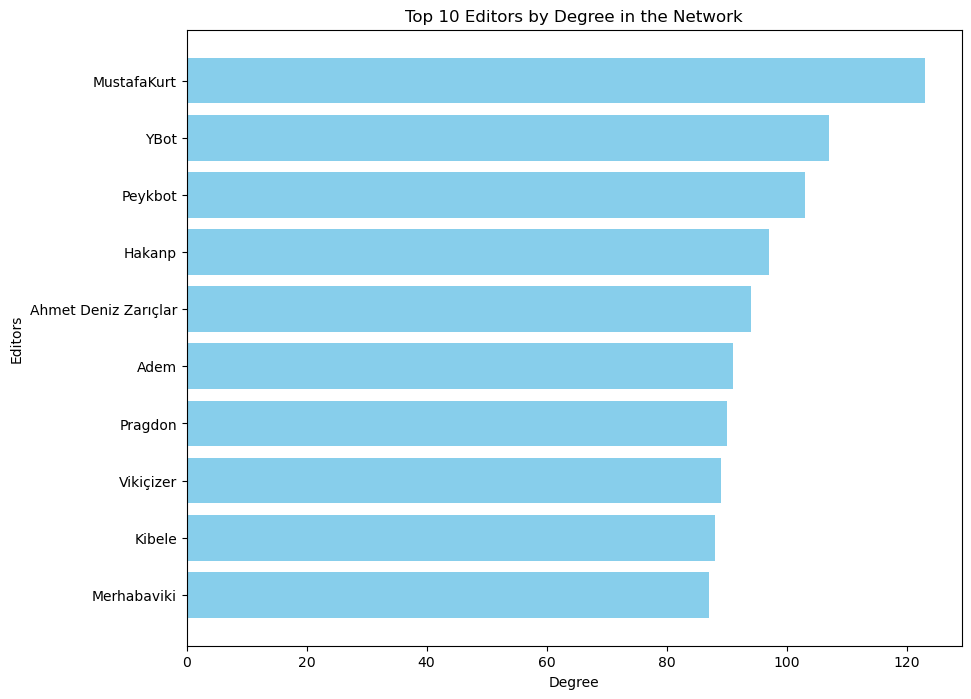

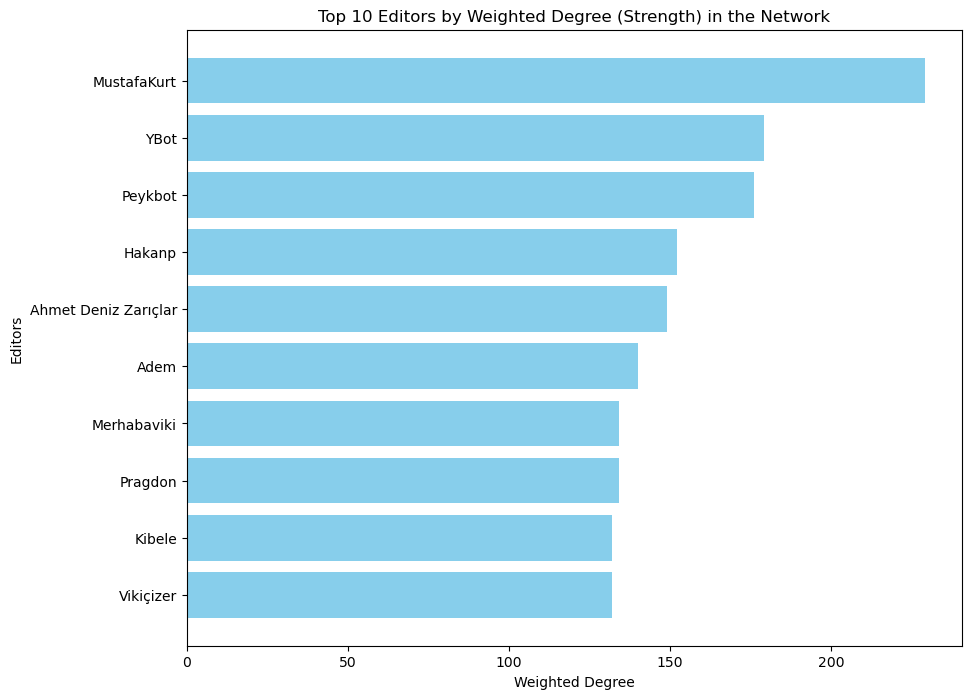

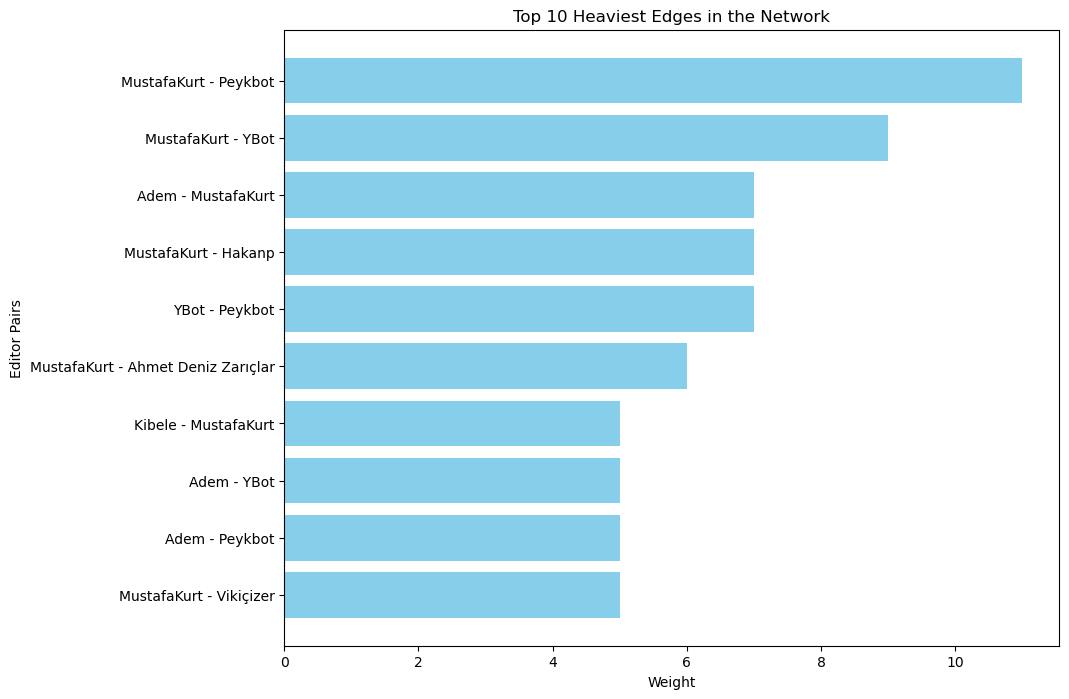

Network graph saved successfully!


In [17]:
# Create a new graph for editors
G_editors = nx.Graph()

# Add nodes for editors, with attributes for each politician they edit, the parties, and the total edits count
for editor, data in editors.items():
    politicians_dict, parties_dict, total_edits, byte_dict = data
    # Prepare node attributes
    attributes = {
        'total_edits': total_edits
    }

    # Determine the mostly edited party and check if it comprises more than 50% of total edits
    if parties_dict:
        party_counts = Counter(parties_dict)
        most_common_party, most_common_edits = party_counts.most_common(1)[0]
        party_indicator = {party: True for party in parties_dict}  # Binary indicator for party editing
        attributes.update(party_indicator)  # Add party indicators
        attributes['mostly_edited_party_edit_count'] = most_common_edits  # Most edits to a single party
        attributes["mostly_edited_party"] = most_common_party

        if most_common_edits / total_edits >= 0.75:
            attributes['party'] = most_common_party
        else:
            attributes['party'] = 'no_party'

    G_editors.add_node(editor, **attributes)

# Add edges between editors if they edited the same politician
for editor1, editor2 in combinations(editors.keys(), 2):
    politicians1 = editors[editor1][0]
    politicians2 = editors[editor2][0]
    shared_politicians = set(politicians1).intersection(politicians2)
    
    if shared_politicians:
        G_editors.add_edge(editor1, editor2, weight=len(shared_politicians))

# Calculate and plot the top 10 editors by degree
degrees = sorted(G_editors.degree(), key=lambda x: x[1], reverse=True)[:10]
labels = [degree[0] for degree in degrees]
degree_values = [degree[1] for degree in degrees]
plt.figure(figsize=(10, 8))
plt.barh(labels, degree_values, color='skyblue')
plt.xlabel('Degree')
plt.ylabel('Editors')
plt.title('Top 10 Editors by Degree in the Network')
plt.gca().invert_yaxis()  # Invert y axis to have the highest degree at the top
plt.show()

# Calculate and plot the top 10 editors by weighted degree
weighted_degrees = sorted(G_editors.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:10]
labels = [degree[0] for degree in weighted_degrees]
weighted_degree_values = [degree[1] for degree in weighted_degrees]

plt.figure(figsize=(10, 8))
plt.barh(labels, weighted_degree_values, color='skyblue')
plt.xlabel('Weighted Degree')
plt.ylabel('Editors')
plt.title('Top 10 Editors by Weighted Degree (Strength) in the Network')
plt.gca().invert_yaxis()  # Invert y axis to have the highest weighted degree at the top
plt.show()

# Calculate and plot the top 10 heaviest edges by weight
edges = sorted(G_editors.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
labels = [f"{edge[0]} - {edge[1]}" for edge in edges]
weights = [edge[2]['weight'] for edge in edges]
plt.figure(figsize=(10, 8))
plt.barh(labels, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Editor Pairs')
plt.title('Top 10 Heaviest Edges in the Network')
plt.gca().invert_yaxis()  # Invert y axis to have the heaviest edge on top
plt.show()



# Export the graph to a GEXF file suitable for Gephi
nx.write_gexf(G_editors, "Editors_Network.gexf")
print("Network graph saved successfully!")


# Node editors, edge politicians (NON-REGISTERED VERSION)

In [18]:
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import math

# Create a new graph for non-registered editors
G_nonreg_editors = nx.Graph()

# Add nodes for non-registered editors, with attributes for each politician they edit, the parties, and the total edits count
for editor, data in nonreg_editors.items():
    politicians_dict, parties_dict, total_edits, ip_address = data
    
    # Prepare node attributes
    attributes = {
        'total_edits': total_edits,
        'ip': ip_address     # IP address itself
    }

    # Determine the mostly edited party and check if it comprises more than 50% of total edits
    if parties_dict:
        party_counts = Counter(parties_dict)
        most_common_party, most_common_edits = party_counts.most_common(1)[0]
        party_indicator = {party: True for party in parties_dict}  # Binary indicator for party editing
        attributes.update(party_indicator)  # Add party indicators
        attributes['mostly_edited_party_edit_count'] = most_common_edits  # Most edits to a single party
        attributes["mostly_edited_party"] = most_common_party

        if most_common_edits / total_edits >= 0.75:
            attributes['party'] = most_common_party
        else:
            attributes['party'] = 'no_party'


    G_nonreg_editors.add_node(editor, **attributes)

# Add edges between non-registered editors if they edited the same politician
for editor1, editor2 in combinations(nonreg_editors.keys(), 2):
    politicians1 = nonreg_editors[editor1][0]
    politicians2 = nonreg_editors[editor2][0]
    shared_politicians = set(politicians1).intersection(politicians2)

    if shared_politicians:
        G_nonreg_editors.add_edge(editor1, editor2, weight=len(shared_politicians))
        
    
# Export the graph to a GEXF file suitable for Gephi;
nx.write_gexf(G_nonreg_editors, "NonRegistered_Editors_Network.gexf")
print("Network graph saved successfully!")


Network graph saved successfully!


## Node politicians, edge editors

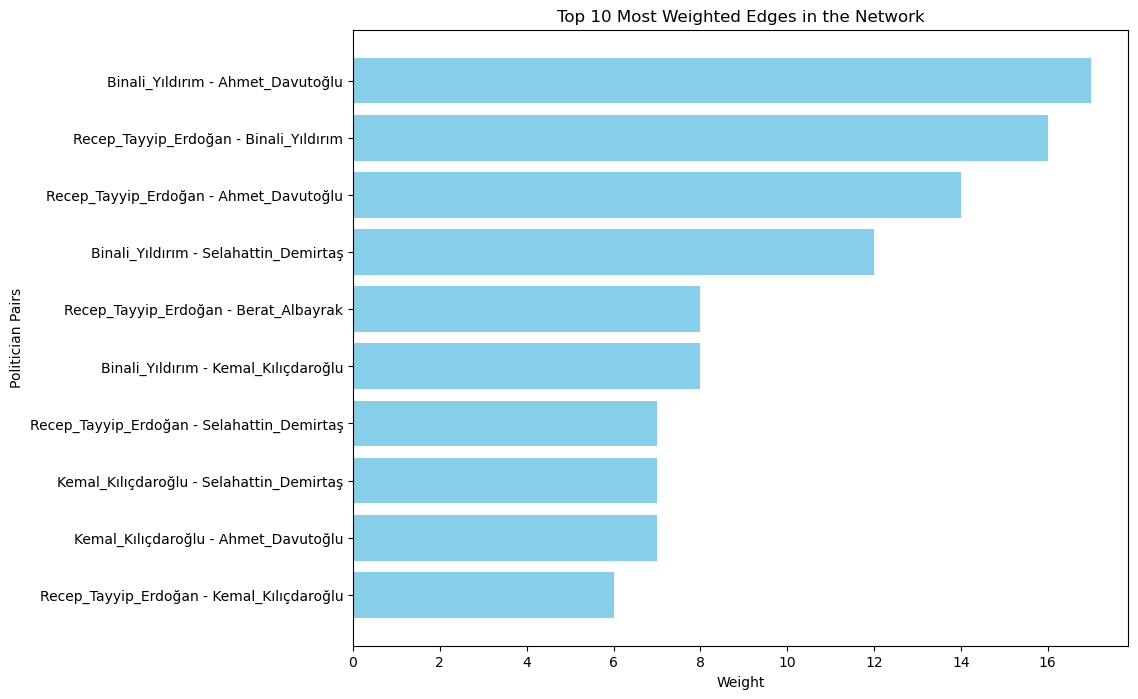

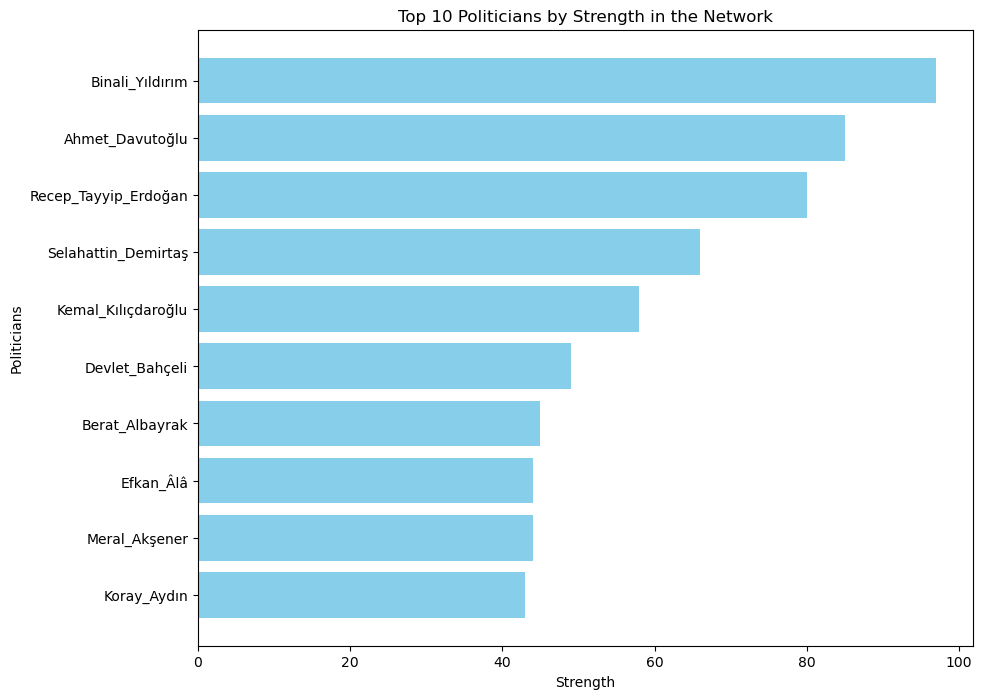

Network graph saved successfully!


In [19]:
# Initialize the graph
G_politicians = nx.Graph()

# Add nodes with the party attribute
for politician, (edits, party) in politicians.items():
    G_politicians.add_node(politician, party=party)

# Iterate over each pair of politicians to determine shared editors and the number of edits they share
for pol1, pol2 in combinations(politicians.keys(), 2):
    editors1 = politicians[pol1][0]
    editors2 = politicians[pol2][0]

    # Find common editors
    common_editors = set(editors1).intersection(editors2)

    if common_editors:
        G_politicians.add_edge(pol1, pol2, weight=len(common_editors))


# Finding the top 10 heaviest edges
edges = sorted(G_politicians.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

# Extracting the labels and weights for the bar graph
labels = [f"{edge[0]} - {edge[1]}" for edge in edges]
weights = [edge[2]['weight'] for edge in edges]

# Creating the bar graph
plt.figure(figsize=(10, 8))
plt.barh(labels, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Politician Pairs')
plt.title('Top 10 Most Weighted Edges in the Network')
plt.gca().invert_yaxis()  # Invert y axis to have the heaviest edge on top
plt.show()

# Calculate and plot the top 10 politicians by strength (weighted degree)
strengths = sorted(G_politicians.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:10]
labels = [strength[0] for strength in strengths]
strength_values = [strength[1] for strength in strengths]

plt.figure(figsize=(10, 8))
plt.barh(labels, strength_values, color='skyblue')
plt.xlabel('Strength')
plt.ylabel('Politicians')
plt.title('Top 10 Politicians by Strength in the Network')
plt.gca().invert_yaxis()  # Invert y axis to have the highest strength at the top
plt.show()

# Export the graph to a GEXF file suitable for Gephi
nx.write_gexf(G_politicians, "Politicians_Network.gexf")
print("Network graph saved successfully!")

# Enter a query name

In [15]:
query_name = "Recep_Tayyip_Erdoğan"

query_start_str = "1.10.2014"
query_end_str = "1.7.2015"

print(politicians["Mansur_Yavaş"])

[{}, 'CHP']


## Page size changes in time for a given politician

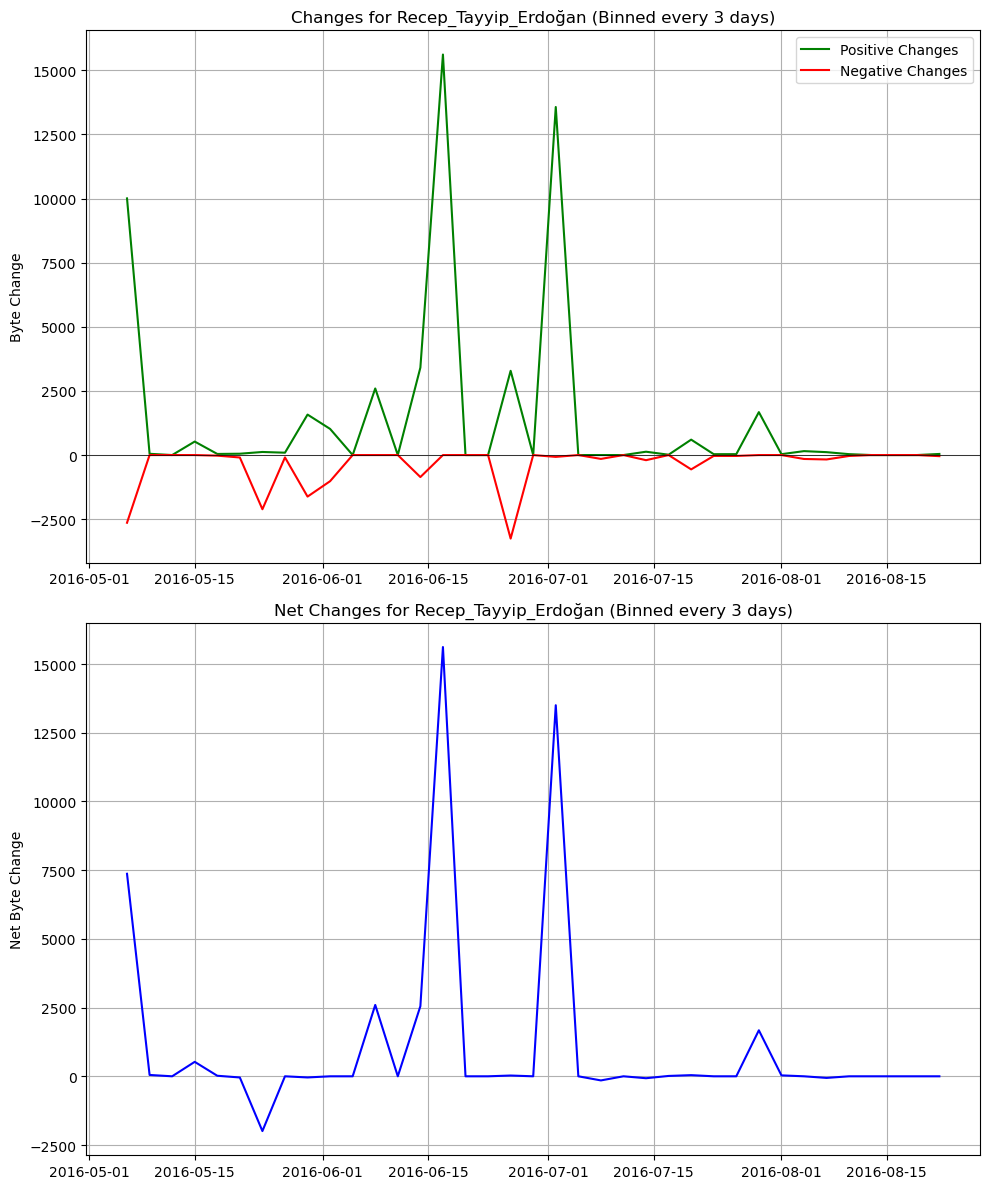

In [16]:
def plot_changes_for_politician(politician_name, positive_changes, negative_changes, net_changes, bin_days=7):
    # Check if the politician's data exists in the dictionaries
    if (politician_name in positive_changes and
        politician_name in negative_changes and
        politician_name in net_changes):

        # Convert dictionaries to pandas Series
        pos_series = pd.Series(positive_changes[politician_name])
        neg_series = pd.Series(negative_changes[politician_name])
        net_series = pd.Series(net_changes[politician_name])

        # Resample the series to the specified bin size in days and sum the data
        pos_resampled = pos_series.resample(f'{bin_days}D').sum()
        neg_resampled = neg_series.resample(f'{bin_days}D').sum()
        net_resampled = net_series.resample(f'{bin_days}D').sum()

        # Create a figure with 2 subplots, one above the other
        fig, axs = plt.subplots(2, 1, figsize=(10, 12))

        # Plotting positive and negative changes on the same subplot
        axs[0].plot(pos_resampled.index, pos_resampled.values, linestyle='-', color='green', label='Positive Changes')
        axs[0].plot(neg_resampled.index, neg_resampled.values, linestyle='-', color='red', label='Negative Changes')
        axs[0].set_title(f'Changes for {politician_name} (Binned every {bin_days} days)')
        axs[0].set_ylabel('Byte Change')
        axs[0].grid(True)
        axs[0].axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at y=0
        axs[0].legend()

        # Plotting net changes
        axs[1].plot(net_resampled.index, net_resampled.values, linestyle='-', color='blue')
        axs[1].set_title(f'Net Changes for {politician_name} (Binned every {bin_days} days)')
        axs[1].set_ylabel('Net Byte Change')
        axs[1].grid(True)
        
        # Improve layout and show plot
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data available for {politician_name}")

# Example usage
plot_changes_for_politician(query_name, positive_changes, negative_changes, net_changes, bin_days=3)